In [16]:
# For version check
from platform import python_version
from importlib.metadata import version

In [17]:
import networkx as nx
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns

In [18]:
print('Python: ', python_version())

print('pandas: ', pd.__version__)
print('networkx: ', nx.__version__)
print('matplotlib: ', version('matplotlib'))
print('numpy: ', version('numpy'))
print('seaborn: ', version('seaborn'))

Python:  3.10.1
pandas:  1.4.2
networkx:  2.8.1
matplotlib:  3.5.2
numpy:  1.22.3
seaborn:  0.11.2


Python:  3.10.1\
pandas:  1.4.2\
networkx:  2.8.1\
matplotlib:  3.5.2\
numpy:  1.22.3\
seaborn:  0.11.2

In [19]:
plt.rcParams["figure.figsize"] = 7, 6
sns.set_style("whitegrid")

# Age gene classes from Liebeskind

Download from [age gene classes](https://github.com/marcottelab/Gene-Ages) (from [Gene-Ages/Main/](https://github.com/marcottelab/Gene-Ages/tree/master/Main)), Liebeskind et. al. 2016, and mapping to GRNs.



## Contents:
1. [Yeast GRN](#Yeast).\
   1.1. [Mapping age classes to GRN](#Yeast_mapping).\
   1.2. [Degree connectivity and clustering of GRN](#Yeast_connectivity).\
   1.3. [Heatmap](#Yeast_heatmap).\
   1.4. [Edge "len"](#Yeast_len).
   
2. [Mouse GRN](#Mouse).\
   2.1. [Mapping age classes to GRN](#Mouse_mapping).\
   2.2. [Degree connectivity and clustering of GRN](#Mouse_connectivity).\
   2.3. [Heatmap](#Mouse_heatmap).\
   2.4. [Edge "len"](#Mouse_len).

3. [Human GRN](#Human).\
   3.1. [Mapping age classes to GRN](#Human_mapping).\
   3.2. [Degree connectivity and clustering of GRN](#Human_connectivity).\
   3.3. [Heatmap](#Human_heatmap).\
   3.4. [Edge "len"](#Human_len).

In [20]:
# load GRNs:

# yeast
yeast_data = pd.read_csv('../data/01_GRNs/yeast.txt', sep='\t')
yeast_graph = nx.from_pandas_edgelist(yeast_data, source='Tf', target='Tg', 
                                      create_using=nx.DiGraph())

# mouse
mouse_data = pd.read_csv('../data/01_GRNs/trrust_rawdata.mouse.tsv', 
                         sep='\t', header=None, 
                         names=['TF', 'Target', 'Mode', 'PMID'])
mouse_graph = nx.from_pandas_edgelist(mouse_data, 'TF', 'Target', ['Mode', 'PMID'], 
                                      create_using=nx.DiGraph())

# human
human_data = pd.read_csv('../data/01_GRNs/trrust_rawdata.human.tsv', 
                         sep='\t', header=None, 
                         names=['TF', 'Target', 'Mode', 'PMID'])
human_graph = nx.from_pandas_edgelist(human_data, 'TF', 'Target', ['Mode', 'PMID'], 
                                      create_using=nx.DiGraph())

# 1. Yeast  <a name="Yeast"></a>

## 1.1. Download and mapping age classes to nx graph <a name="Yeast_mapping"></a>

In [21]:
# load age classes
yeast_classes = pd.read_csv('../data/02_protein_ages/main_YEAST.csv')
print(yeast_classes.shape)

yeast_classes = yeast_classes.rename(columns={"Unnamed: 0": "Protein"})
yeast_classes.head()

(5000, 16)


,Protein,Cellular_organisms,Euk_Archaea,Euk+Bac,Eukaryota,Opisthokonta,Dikarya,Ascomycota,Saccharomyceta,modeAge,NumDBsContributing,NumDBsFiltered,entropy,NodeError,Bimodality,HGT_flag
0,A2P2R3,0.800,0.0,0.2,0.000000,0.0,0.000000,0.0,0.000000,Cellular_organisms,5,1,0.500402,0.0,0.000000,False
1,D6VTK4,0.000,0.0,0.0,0.000000,0.0,0.000000,0.9,0.100000,Ascomycota,10,0,0.325083,0.2,0.107143,False
2,D6W196,0.000,0.0,0.0,0.500000,0.0,0.300000,0.0,0.200000,Eukaryota,10,2,1.029653,2.86363636364,2.236866,False
3,O13297,0.000,0.0,0.0,0.272727,0.0,0.454545,0.0,0.272727,Dikarya,11,0,1.067090,2.94545454545,0.120000,False
4,O13516,0.375,0.5,0.0,0.125000,0.0,0.000000,0.0,0.000000,Euk_Archaea,8,1,0.974315,0.777777777778,-0.220779,False


In [22]:
# Finds too few matches through uniprot:

# for uniprot mapping - https://www.uniprot.org/uploadlists/
# yeast_ID_UniProt = list(yeast_classes['Protein'])
# with open('../data/02_age_classes/yeast_ID_UniProt.txt', 'w') as f:
#     for el in yeast_ID_UniProt:
#          f.write(el+' ')

# yeast_prot_genes_UNI = pd.read_csv('../data/02_age_classes/Yeast_UniProtMapping.txt',
#                                  sep='\t',
#                                  engine='python',
#                                  names=['Protein', 'Gene'],
#                                  header=1)

Finds too few matches through uniprot, we will use the [yeastgenome](https://yeastmine.yeastgenome.org/yeastmine/begin.do). 

> ! Get list of IDs through web server.

No matches found for: 
1. P43546 
2. P0CD89 
3. P0CD92

In [23]:
# load protein-gene table from yeast_org:
yeast_prot_genes = pd.read_csv('../data/02_age_classes/yeast_org_summary.csv', sep=' ')
yeast_prot_genes = yeast_prot_genes[['input', 'secondaryIdentifier']]
yeast_prot_genes = yeast_prot_genes.rename(columns = {'input':'Protein', 'secondaryIdentifier':'Gene'})

yeast_prot_genes.head()

,Protein,Gene
0,P53266,YGR112W
1,P38885,YHR199C
2,P14693,YHR083W
3,P40042,YER066W
4,P38990,YER129W


In [24]:
# add gene names to protein classes table:
yeast_classes = yeast_classes.merge(yeast_prot_genes, how='outer', on=['Protein'])
yeast_classes.head()

,Protein,Cellular_organisms,Euk_Archaea,Euk+Bac,Eukaryota,Opisthokonta,Dikarya,Ascomycota,Saccharomyceta,modeAge,NumDBsContributing,NumDBsFiltered,entropy,NodeError,Bimodality,HGT_flag,Gene
0,A2P2R3,0.800,0.0,0.2,0.000000,0.0,0.000000,0.0,0.000000,Cellular_organisms,5,1,0.500402,0.0,0.000000,False,YMR084W
1,D6VTK4,0.000,0.0,0.0,0.000000,0.0,0.000000,0.9,0.100000,Ascomycota,10,0,0.325083,0.2,0.107143,False,YFL026W
2,D6W196,0.000,0.0,0.0,0.500000,0.0,0.300000,0.0,0.200000,Eukaryota,10,2,1.029653,2.86363636364,2.236866,False,YNL083W
3,O13297,0.000,0.0,0.0,0.272727,0.0,0.454545,0.0,0.272727,Dikarya,11,0,1.067090,2.94545454545,0.120000,False,YPL228W
4,O13516,0.375,0.5,0.0,0.125000,0.0,0.000000,0.0,0.000000,Euk_Archaea,8,1,0.974315,0.777777777778,-0.220779,False,YPL081W


In [25]:
# Let's leave only those lines that are needed for our GRN:
yest_TFTG = set(list(yeast_data.Tf) + list(yeast_data.Tg))
yeast_gene_ages = yeast_classes.query('Gene in @yest_TFTG')
print(yeast_gene_ages.shape)

(3437, 17)


In [26]:
# save to csv
yeast_gene_ages[['Gene', 'modeAge']].to_csv('../data/02_age_classes/yeast_gene_ages_L.csv', index=False)

In [27]:
# Class distribution
yeast_sum_ages = yeast_gene_ages.groupby('modeAge', as_index=0).count()[['modeAge', 'Gene']]
yeast_sum_ages.loc["Total"] = yeast_sum_ages.sum()
yeast_sum_ages.loc['Total', 'modeAge'] = 'Total'
yeast_sum_ages.rename(columns = {'modeAge':'Age class', 'Gene': 'Genes number'}, inplace = True)
yeast_sum_ages

,Age class,Genes number
0,Ascomycota,111
1,Cellular_organisms,372
2,Dikarya,241
3,Euk+Bac,505
4,Euk_Archaea,104
5,Eukaryota,1364
6,Opisthokonta,186
7,Saccharomyceta,554
Total,Total,3437


In [28]:
# Add New info to nx Graf:
yeast_attrs = yeast_gene_ages[['Gene', 'modeAge']].set_index('Gene').T.to_dict('dict')
nx.set_node_attributes(yeast_graph, yeast_attrs) 

In [29]:
# Add New info to pandas df:
yeast_gene_ages = yeast_gene_ages.rename(columns = {'Gene':'Tf'})
yeast_data['TF_age'] =  yeast_data.merge(yeast_gene_ages[['Tf', 'modeAge']], how='left', on=['Tf']).modeAge

yeast_gene_ages = yeast_gene_ages.rename(columns = {'Tf':'Tg'})
yeast_data['Tg_age'] =  yeast_data.merge(yeast_gene_ages[['Tg', 'modeAge']], how='left', on=['Tg']).modeAge

# return name
yeast_gene_ages = yeast_gene_ages.rename(columns = {'Tg':'Gene'})

In [30]:
# save results
yeast_data.to_csv('../data/02_age_classes/yeast_classes.csv', index=0)

yeast_data.head()

,Tf,Tg,TF_age,Tg_age
0,YAL051W,YAL016W,Saccharomyceta,Eukaryota
1,YAL051W,YAL034WA,Saccharomyceta,NaN
2,YAL051W,YAL035CA,Saccharomyceta,NaN
3,YAL051W,YAL035W,Saccharomyceta,Euk_Archaea
4,YAL051W,YAL036C,Saccharomyceta,Cellular_organisms


## 1.2. Degree connectivity and clustering <a name="Yeast_connectivity"></a>

In [163]:
# load pandas
# yeast_graph = nx.from_pandas_edgelist(yeast_data, 'Tf', 'Tg', create_using=nx.DiGraph())
# yeast_attrs = yeast_gene_ages[['Gene', 'modeAge']].set_index('Gene').T.to_dict('dict')
# nx.set_node_attributes(yeast_graph, yeast_attrs) 

In [164]:
yeast_gene_ages_dropped = yeast_gene_ages[['Gene', 'modeAge']]

yeast_ndegree = pd.DataFrame.from_dict(dict(yeast_graph.degree()), orient='index').reset_index(level=0)
yeast_ndegree.columns = ['Gene', 'Node_Degree']

yeast_ndegree = yeast_ndegree.merge(yeast_gene_ages_dropped, how='outer', on=['Gene'])
yeast_ndegree.head()

,Gene,Node_Degree,modeAge
0,YAL051W,61,Saccharomyceta
1,YAL016W,4,Eukaryota
2,YAL034WA,3,NaN
3,YAL035CA,1,NaN
4,YAL035W,4,Euk_Archaea


In [165]:
classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Dikarya', 'Ascomycota', 'Saccharomyceta']

yeast_ndegree['modeAge'].fillna('no info', inplace=True)
yeast_ndegree['Age'] = yeast_ndegree['modeAge'].apply(lambda x: classes.index(x))

Text(0, 0.5, 'Age class')

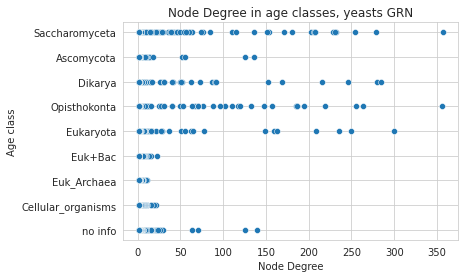

In [166]:
plt.figure(figsize=(6, 4))
yeast_ndegree['modeAge'] = [classes.index(x) for x in yeast_ndegree['modeAge']]
sns.scatterplot(y="modeAge", x="Node_Degree", data=yeast_ndegree)
plt.yticks(range(len(classes)), classes)
plt.title('Node Degree in age classes, yeasts GRN')
plt.xlabel('Node Degree')
plt.ylabel('Age class')
#plt.savefig('../data/02_plots/yeast_node_degree.png')
#plt.close()

#### Сonnectivity

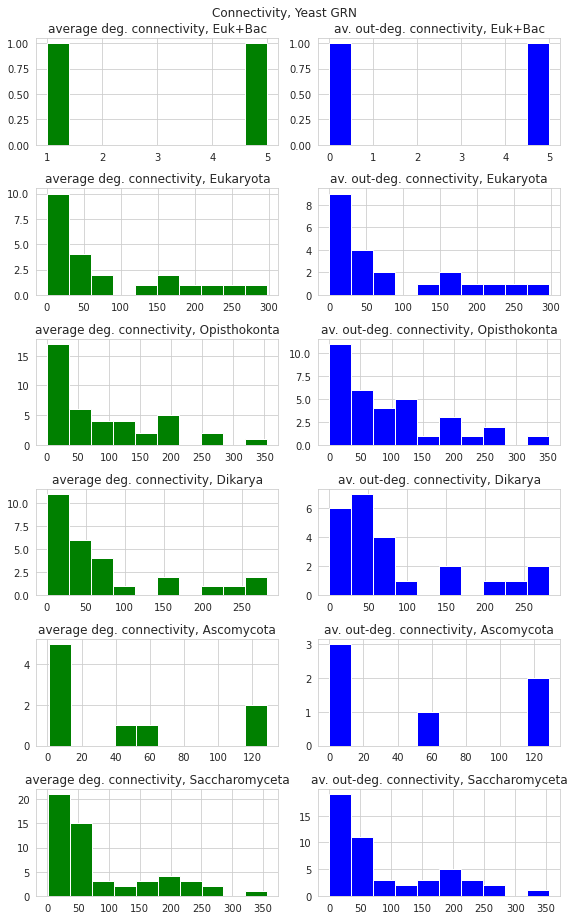

In [167]:
classes = ['Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Dikarya', 'Ascomycota', 'Saccharomyceta']

plt.rcParams["figure.figsize"] = 8, 13

fig, axes = plt.subplots(6, 2)

for i, class_ in enumerate(classes):
    temp_data = yeast_data[yeast_data['TF_age'] == class_]
    
    temp_graph = nx.from_pandas_edgelist(temp_data, 
                                         'Tf', 'Tg', 
                                         create_using=nx.DiGraph())

    #  is the average nearest neighbor degree of nodes with degree k
    temp_av_conn = nx.average_degree_connectivity(temp_graph)
    temp_out_conn = nx.average_degree_connectivity(temp_graph, source='out')

    axes[i-2, 0].hist(temp_av_conn, color='g')
    axes[i-2, 0].set_title(f'average deg. connectivity, {class_}')
    
    axes[i-2, 1].hist(temp_out_conn, color='b')
    axes[i-2, 1].set_title(f'av. out-deg. connectivity, {class_}')

plt.suptitle('Сonnectivity, Yeast GRN')
plt.tight_layout() 
plt.show()

#plt.savefig('../data/02_plots/yeast_connectivity.png')
#plt.close()

#### Clustering

In [168]:
clustering_table = pd.DataFrame(columns=['organism','class', 'type', 'clust_coefficient'])

In [169]:
# TF age

classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Dikarya', 'Ascomycota', 'Saccharomyceta']

for i, class_ in enumerate(classes[1:]):
    temp_data = yeast_data[yeast_data['TF_age'] == class_]
    
    if temp_data.empty:
        continue
    
    temp_graph = nx.from_pandas_edgelist(temp_data, 
                                         'Tf', 'Tg',
                                         create_using=nx.DiGraph())
    
    clustering_table.loc[len(clustering_table)] = ['yeasts', class_, 'TF', nx.average_clustering(temp_graph)]
    
    print(f'Clastering (transitivity): \t{round(nx.transitivity(temp_graph), 4)}, yeasts, {class_}')
    print(f'Clastering coeficient:\t\t{round(nx.average_clustering(temp_graph), 6)}, yeasts, {class_}')
    print('----------')

Clastering (transitivity): 	0, yeasts, Euk+Bac
Clastering coeficient:		0.0, yeasts, Euk+Bac
----------
Clastering (transitivity): 	0.0001, yeasts, Eukaryota
Clastering coeficient:		0.004102, yeasts, Eukaryota
----------
Clastering (transitivity): 	0.001, yeasts, Opisthokonta
Clastering coeficient:		0.057346, yeasts, Opisthokonta
----------
Clastering (transitivity): 	0.0003, yeasts, Dikarya
Clastering coeficient:		0.010275, yeasts, Dikarya
----------
Clastering (transitivity): 	0.0001, yeasts, Ascomycota
Clastering coeficient:		0.005752, yeasts, Ascomycota
----------
Clastering (transitivity): 	0.0009, yeasts, Saccharomyceta
Clastering coeficient:		0.038195, yeasts, Saccharomyceta
----------


In [170]:
# Target age

classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Dikarya', 'Ascomycota', 'Saccharomyceta']

for i, class_ in enumerate(classes[1:]):
    temp_data = yeast_data[yeast_data['Tg_age'] == class_]
    
    if temp_data.empty:
        continue
    
    temp_graph = nx.from_pandas_edgelist(temp_data, 
                                         'Tf', 'Tg', 
                                         create_using=nx.DiGraph())

    clustering_table.loc[len(clustering_table)] = ['yeasts', class_, 'TG', nx.average_clustering(temp_graph)]

    print(f'Clastering (transitivity):\t{round(nx.transitivity(temp_graph), 4)}, yeasts, {class_}')
    print(f'Clastering coeficient:\t\t{round(nx.average_clustering(temp_graph), 6)}, yeasts, {class_}')
    print('----------')

Clastering (transitivity):	0, yeasts, Cellular_organisms
Clastering coeficient:		0.0, yeasts, Cellular_organisms
----------
Clastering (transitivity):	0, yeasts, Euk_Archaea
Clastering coeficient:		0.0, yeasts, Euk_Archaea
----------
Clastering (transitivity):	0.0001, yeasts, Euk+Bac
Clastering coeficient:		0.000464, yeasts, Euk+Bac
----------
Clastering (transitivity):	0.0002, yeasts, Eukaryota
Clastering coeficient:		0.003586, yeasts, Eukaryota
----------
Clastering (transitivity):	0.0143, yeasts, Opisthokonta
Clastering coeficient:		0.012831, yeasts, Opisthokonta
----------
Clastering (transitivity):	0.0061, yeasts, Dikarya
Clastering coeficient:		0.007354, yeasts, Dikarya
----------
Clastering (transitivity):	0, yeasts, Ascomycota
Clastering coeficient:		0.0, yeasts, Ascomycota
----------
Clastering (transitivity):	0.0059, yeasts, Saccharomyceta
Clastering coeficient:		0.014439, yeasts, Saccharomyceta
----------


In [171]:
clustering_table

,organism,class,type,clust_coefficient
0,yeasts,Euk+Bac,TF,0.000000
1,yeasts,Eukaryota,TF,0.004102
2,yeasts,Opisthokonta,TF,0.057346
3,yeasts,Dikarya,TF,0.010275
4,yeasts,Ascomycota,TF,0.005752
5,yeasts,Saccharomyceta,TF,0.038195
6,yeasts,Cellular_organisms,TG,0.000000
7,yeasts,Euk_Archaea,TG,0.000000
8,yeasts,Euk+Bac,TG,0.000464
9,yeasts,Eukaryota,TG,0.003586


## 1.3. Heatmap <a name="Yeast_heatmap"></a>

In [172]:
# heatmap

# Substituting nans with "no info"
yeast_data[['Tg_age', 'TF_age']] = yeast_data[['Tg_age', 'TF_age']].replace(np.nan, 'no info')

In [173]:
heatmap_y = pd.crosstab(yeast_data.TF_age, yeast_data.Tg_age, normalize=True)
heatmap_y

Tg_age,Ascomycota,Cellular_organisms,Dikarya,Euk+Bac,Euk_Archaea,Eukaryota,Opisthokonta,Saccharomyceta,no info
TF_age,,,,,,,,,
Ascomycota,0.000311,0.004506,0.002020,0.005049,0.000388,0.006137,0.000466,0.002719,0.007302
Dikarya,0.004039,0.013517,0.007846,0.018255,0.004273,0.045056,0.006525,0.021052,0.041404
Euk+Bac,0.000000,0.000078,0.000000,0.000233,0.000000,0.000000,0.000000,0.000078,0.000000
Eukaryota,0.003340,0.012351,0.008856,0.015303,0.002719,0.045444,0.005360,0.019498,0.032859
Opisthokonta,0.007457,0.021906,0.014449,0.030218,0.008001,0.071079,0.010332,0.037287,0.071234
Saccharomyceta,0.009400,0.036200,0.019032,0.047231,0.007380,0.096170,0.013672,0.042880,0.081644
no info,0.001088,0.002486,0.002253,0.003573,0.000544,0.007457,0.001476,0.004816,0.013750


Text(0.5, 1.0, '          with clusterization coefficients')

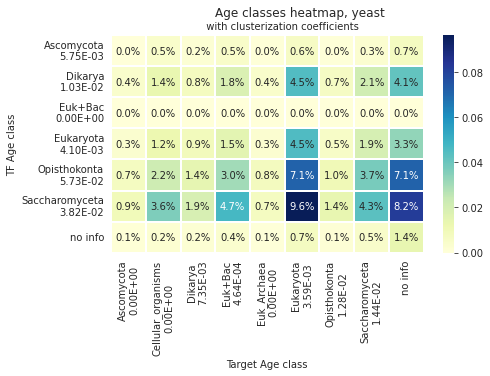

In [174]:
plt.rcParams["figure.figsize"] = 7, 4


xlabels = ['Ascomycota', 'Cellular_organisms', 'Dikarya', 'Euk+Bac', 'Euk_Archaea',
           'Eukaryota', 'Opisthokonta', 'Saccharomyceta'] # labels for x-axis

ylabels = ['Ascomycota', 'Dikarya','Euk+Bac', 
           'Eukaryota', 'Opisthokonta', 'Saccharomyceta'] # labels for y-axis

x_axis_labels = []
y_axis_labels = []

for label in xlabels:
    coeff = clustering_table[(clustering_table['organism'] == 'yeasts') 
                             & (clustering_table['class'] == label)
                             & (clustering_table['type'] == 'TG')].clust_coefficient.values[0]

    x_axis_labels.append(f'{label}\n{coeff:.2E}')
    
x_axis_labels.append('no info')
    
for label in ylabels:
    coeff = clustering_table[(clustering_table['organism'] == 'yeasts') 
                             & (clustering_table['class'] == label)
                             & (clustering_table['type'] == 'TF')].clust_coefficient.values[0]

    y_axis_labels.append(f'{label}\n{coeff:.2E}')

y_axis_labels.append('no info')

s = sns.heatmap(heatmap_y,
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt=".1%",
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
#plt.setp(s.get_xticklabels(), rotation=70)

plt.suptitle('Age classes heatmap, yeast')
plt.title('          with clusterization coefficients', size=10)

#plt.savefig('../data/02_plots/yeast_heatmap_01.png')
#plt.close()

#### Target/TF

In [175]:
tf_ages_count = yeast_data.groupby(['Tf', 'TF_age'], as_index=0).count().groupby('TF_age', as_index=0).count()[['TF_age', 'Tf']]
tg_ages_count = yeast_data.groupby(['Tg', 'Tg_age'], as_index=0).count().groupby('Tg_age', as_index=0).count()[['Tg_age', 'Tg']]

In [176]:
ages_list = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
             'Opisthokonta', 'Dikarya', 'Ascomycota', 'Saccharomyceta']
tf_tg_count = heatmap_y.copy()

for tf_age in ages_list:
    for tg_age in ages_list:
        new_table = yeast_data[(yeast_data.Tg_age == tg_age) & (yeast_data.TF_age == tf_age)]
        if new_table[['Tf']].nunique().iloc[0] != 0:
            new_value = new_table[['Tg']].nunique().iloc[0] / new_table[['Tf']].nunique().iloc[0]
        else:
            new_value = 0
        tf_tg_count.loc[tf_age, tg_age] = new_value

In [177]:
tf_tg_count

Tg_age,Ascomycota,Cellular_organisms,Dikarya,Euk+Bac,Euk_Archaea,Eukaryota,Opisthokonta,Saccharomyceta,no info
TF_age,,,,,,,,,
Ascomycota,2.000000,9.000000,4.600000,11.600000,1.666667,12.166667,2.000000,5.500000,14.500000
Dikarya,3.083333,6.238095,4.470588,8.857143,2.588235,21.904762,3.157895,9.619048,16.739130
Euk+Bac,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000
Eukaryota,2.428571,8.000000,6.066667,8.250000,3.444444,25.750000,4.285714,11.210526,19.611111
Opisthokonta,2.230769,5.612903,3.750000,6.812500,2.666667,17.000000,3.035714,7.818182,15.212121
Saccharomyceta,1.857143,5.468085,3.085106,6.920000,2.033333,15.560000,2.340909,6.687500,12.250000
no info,1.444444,3.000000,2.166667,6.428571,1.750000,10.222222,2.833333,4.636364,9.692308
Cellular_organisms,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Euk_Archaea,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Text(0.5, 1.0, 'TG/TF heatmap, yeast')

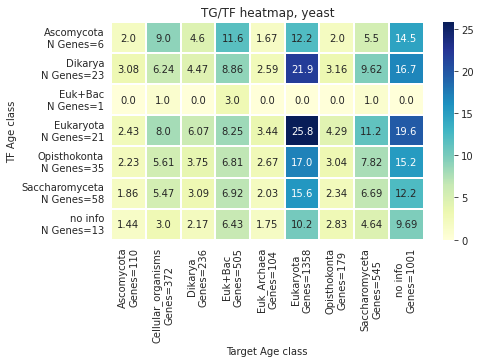

In [178]:
plt.rcParams["figure.figsize"] = 7, 4

xlabels = ['Ascomycota', 'Cellular_organisms', 'Dikarya', 'Euk+Bac', 'Euk_Archaea',
           'Eukaryota', 'Opisthokonta', 'Saccharomyceta', 'no info'] # labels for x-axis

ylabels = ['Ascomycota', 'Dikarya','Euk+Bac', 
           'Eukaryota', 'Opisthokonta', 'Saccharomyceta', 'no info'] # labels for y-axis

x_axis_labels = []
y_axis_labels = []

for label in xlabels:
    x_axis_labels.append(f'{label}\nGenes={tg_ages_count[tg_ages_count.Tg_age == label].Tg.iloc[0]}')
    
#x_axis_labels.append('no info')
    
for label in ylabels:
    y_axis_labels.append(f'{label}\nN Genes={tf_ages_count[tf_ages_count.TF_age == label].Tf.iloc[0]}')

#y_axis_labels.append('no info')

s = sns.heatmap(tf_tg_count.iloc[:-2,:],
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt=".3",
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
#plt.setp(s.get_xticklabels(), rotation=70)

plt.title('TG/TF heatmap, yeast')
#plt.savefig('../data/02_plots/yeast_heatmap_02.png')
#plt.close()

## 1.4.  Edge "len"  <a name="Yeast_len"></a>

(in units of "difference" between ages - ages to number).

In [179]:
classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Dikarya', 'Ascomycota', 'Saccharomyceta']

yeast_data['Tg_age'] = yeast_data['Tg_age'].apply(lambda x: classes.index(x))
yeast_data['TF_age'] = yeast_data['TF_age'].apply(lambda x: classes.index(x))

yeast_data['age_length'] = np.where((yeast_data['TF_age'] == 0) | (yeast_data['Tg_age'] == 0),
                                     -1,
                                     abs(yeast_data['TF_age'] - yeast_data['Tg_age']))

# no info to NAN
yeast_data['age_length'] = yeast_data['age_length'].replace({-1: np.nan})

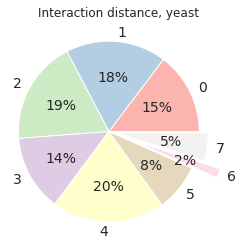

In [183]:
plt.rcParams["figure.figsize"] = 4, 4

idx = [0, 1, 2, 3, 4, 5, 6, 7]
counts = pd.Series(yeast_data['age_length'].value_counts(normalize=True) * 100)
counts.index = counts.index.astype('int64')
counts = counts[idx]

explode = (0, 0, 0, 0, 0, 0, 0.3, 0.1)
counts.plot(kind='pie', fontsize=14, colormap="Pastel1", explode=explode,  autopct='%.0f%%')
plt.axis('equal')
plt.ylabel('')
plt.title('Interaction distance, yeast')
plt.show()
#plt.savefig('../data/02_plots/yeast_age_len.png')
#plt.close()

# 2. Mouse <a name="Mouse"></a>

## 2.1. Download and mapping age classes to nx graph <a name="Mouse_mapping"></a>

In [184]:
mouse_classes = pd.read_csv('../data/02_protein_ages/main_MOUSE.csv')
print(mouse_classes.shape)

mouse_classes = mouse_classes.rename(columns={"Unnamed: 0": "Protein"})
mouse_classes.head()

(19950, 16)


,Protein,Cellular_organisms,Euk_Archaea,Euk+Bac,Eukaryota,Opisthokonta,Eumetazoa,Vertebrata,Mammalia,modeAge,NumDBsContributing,NumDBsFiltered,entropy,NodeError,Bimodality,HGT_flag
0,A0A0A0MQ97,0.000000,0.000000,0.000000,0.0,0.0,0.375000,0.625000,0.000000,Vertebrata,8,5,0.661563,3.33333333333,1.599206,False
1,A0A0A0MQB3,0.333333,0.083333,0.333333,0.0,0.0,0.250000,0.000000,0.000000,Cellular_organisms,12,0,1.286057,3.24242424242,-0.166667,True
2,A0A0A0MQC1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.800000,0.200000,Vertebrata,5,1,0.500402,1.0,NaN,False
3,A0A0A0MQF7,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.000000,Eumetazoa,2,0,-0.000000,2.0,NaN,False
4,A0A0B4J1F6,0.000000,0.000000,0.000000,0.0,0.0,0.142857,0.428571,0.428571,Mammalia,7,5,1.004242,4.16666666667,4.400000,False


In [185]:
# Finds protein-gene matches through uniprot:
# for uniprot mapping - https://www.uniprot.org/uploadlists/

mouse_ID_UniProt = list(mouse_classes['Protein'])

with open('../data/02_age_classes/mouse_ID_UniProt.txt', 'w') as f:
    for el in mouse_ID_UniProt:
        f.write(el+' ')

 ... https://www.uniprot.org/uploadlists/ ...

In [186]:
# load protein-gene table:

mouse_prot_genes = pd.read_csv('../data/02_age_classes/mouse_UniProtMapping.txt',
                                  sep='\t',
                                  engine='python',
                                  names=['Protein', 'Gene'],
                                  header=1)
mouse_prot_genes.head()

,Protein,Gene
0,A0A0A0MQC1,Ighv3-5
1,A0A0A0MQF7,1700025G04Rik
2,A0A0B4J1F6,BC053393
3,A0A0B4J1F8,Smim10l2a
4,A0A0B4J1F9,Tchh


In [187]:
# add gene names to protein classes table:
mouse_classes = mouse_classes.merge(mouse_prot_genes, how='outer', on=['Protein'])
mouse_classes.head()

,Protein,Cellular_organisms,Euk_Archaea,Euk+Bac,Eukaryota,Opisthokonta,Eumetazoa,Vertebrata,Mammalia,modeAge,NumDBsContributing,NumDBsFiltered,entropy,NodeError,Bimodality,HGT_flag,Gene
0,A0A0A0MQ97,0.000000,0.000000,0.000000,0.0,0.0,0.375000,0.625000,0.000000,Vertebrata,8,5,0.661563,3.33333333333,1.599206,False,NaN
1,A0A0A0MQB3,0.333333,0.083333,0.333333,0.0,0.0,0.250000,0.000000,0.000000,Cellular_organisms,12,0,1.286057,3.24242424242,-0.166667,True,NaN
2,A0A0A0MQC1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.800000,0.200000,Vertebrata,5,1,0.500402,1.0,NaN,False,Ighv3-5
3,A0A0A0MQF7,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.000000,Eumetazoa,2,0,-0.000000,2.0,NaN,False,1700025G04Rik
4,A0A0B4J1F6,0.000000,0.000000,0.000000,0.0,0.0,0.142857,0.428571,0.428571,Mammalia,7,5,1.004242,4.16666666667,4.400000,False,BC053393


In [188]:
mouse_classes.shape

(20001, 17)

In [189]:
# Let's leave only those lines that are needed for our GRN:

mouse_TFTG = set(list(mouse_data.TF) + list(mouse_data.Target))

mouse_gene_ages = mouse_classes.query('Gene in @mouse_TFTG')
#mouse_gene_ages = mouse_gene_ages[['Gene', 'modeAge']]
print(mouse_gene_ages.shape)
mouse_gene_ages.head()

(2287, 17)


,Protein,Cellular_organisms,Euk_Archaea,Euk+Bac,Eukaryota,Opisthokonta,Eumetazoa,Vertebrata,Mammalia,modeAge,NumDBsContributing,NumDBsFiltered,entropy,NodeError,Bimodality,HGT_flag,Gene
44,A1L358,0.0,0.0,0.0,0.000000,1.0,0.000000,0.000000,0.000000,Opisthokonta,1,11,-0.000000,5.98484848485,3.577778,False,Mzf1
80,A2A5Z6,0.0,0.0,0.0,0.714286,0.0,0.142857,0.142857,0.000000,Eukaryota,7,5,0.796312,4.10606060606,4.533333,False,Smurf2
87,A2A6M5,0.0,0.0,0.0,0.090909,0.0,0.272727,0.363636,0.272727,Vertebrata,11,1,1.294545,5.37878787879,2.711111,False,Calcoco2
97,A2A7F4,0.0,0.0,0.0,0.000000,0.0,0.384615,0.615385,0.000000,Vertebrata,13,0,0.666278,1.02564102564,0.150794,False,Rlf
114,A2A863,0.0,0.0,0.0,0.000000,0.0,0.583333,0.416667,0.000000,Eumetazoa,12,1,0.679193,2.48717948718,1.988095,False,Itgb4


In [190]:
# Class distribution
mouse_sum_ages = mouse_gene_ages.groupby('modeAge', as_index=0).count()[['modeAge', 'Gene']]
mouse_sum_ages.loc["Total"] = mouse_sum_ages.sum()
mouse_sum_ages.loc['Total', 'modeAge'] = 'Total'
mouse_sum_ages.rename(columns = {'modeAge':'Age class', 'Gene': 'Genes number'}, inplace = True)
mouse_sum_ages

,Age class,Genes number
0,Cellular_organisms,85
1,Euk+Bac,153
2,Euk_Archaea,20
3,Eukaryota,436
4,Eumetazoa,878
5,Mammalia,152
6,Opisthokonta,130
7,Vertebrata,433
Total,Total,2287


#### Add New info to Graf:

In [191]:
mouse_attrs = mouse_gene_ages[['Gene', 'modeAge']].set_index('Gene').T.to_dict('dict')
nx.set_node_attributes(mouse_graph, mouse_attrs) 

/tmp/ipykernel_40539/1163802281.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  mouse_attrs = mouse_gene_ages[['Gene', 'modeAge']].set_index('Gene').T.to_dict('dict')


In [192]:
# Add New info to pandas df:

mouse_gene_ages = mouse_gene_ages.rename(columns = {'Gene':'TF'})
mouse_data['TF_age'] =  mouse_data.merge(mouse_gene_ages[['TF', 'modeAge']], how='left', on=['TF']).modeAge

mouse_gene_ages = mouse_gene_ages.rename(columns = {'TF':'Target'})
mouse_data['Tg_age'] =  mouse_data.merge(mouse_gene_ages[['Target', 'modeAge']], how='left', on=['Target']).modeAge

# return name
mouse_gene_ages = mouse_gene_ages.rename(columns = {'Target':'Gene'})

In [193]:
# save results
mouse_data.to_csv('../data/02_age_classes/trrust_rawdata.mouse_classes.csv')

mouse_data.head()

,TF,Target,Mode,PMID,TF_age,Tg_age
0,Aatf,Bak1,Unknown,22983126,Eukaryota,Eumetazoa
1,Aatf,Bax,Unknown,22983126,Eukaryota,Eumetazoa
2,Aatf,Bbc3,Unknown,22983126,Eukaryota,Mammalia
3,Aatf,Cdkn1a,Unknown,21317046,Eukaryota,Eumetazoa
4,Aatf,Tpt1,Activation,17157788,Eukaryota,Eukaryota


## 2.2. Degree connectivity and clustering <a name="Mouse_connectivity"></a>

In [194]:
mouse_gene_ages_dropped = mouse_gene_ages[['Gene', 'modeAge']]

mouse_ndegree = pd.DataFrame.from_dict(dict(mouse_graph.degree()), orient='index').reset_index(level=0)
mouse_ndegree.columns = ['Gene', 'Node_Degree']

mouse_ndegree = mouse_ndegree.merge(mouse_gene_ages_dropped, how='outer', on=['Gene'])

mouse_ndegree.head()

,Gene,Node_Degree,modeAge
0,Aatf,6,Eukaryota
1,Bak1,3,Eumetazoa
2,Bax,13,Eumetazoa
3,Bbc3,5,Mammalia
4,Cdkn1a,65,Eumetazoa


In [195]:
classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

mouse_ndegree['modeAge'].fillna('no info', inplace=True)
mouse_ndegree['Age'] = mouse_ndegree['modeAge'].apply(lambda x: classes.index(x))

Text(0, 0.5, 'Age class')

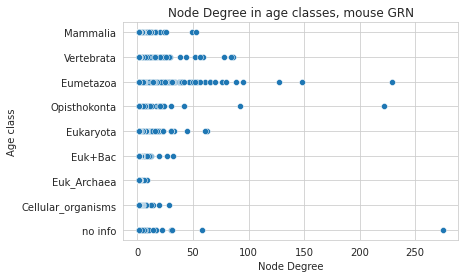

In [196]:
plt.figure(figsize=(6, 4))

mouse_ndegree['modeAge'] = [classes.index(x) for x in mouse_ndegree['modeAge']]
sns.scatterplot(y="modeAge", x="Node_Degree", data=mouse_ndegree)
plt.yticks(range(len(classes)), classes)

plt.title('Node Degree in age classes, mouse GRN')
plt.xlabel('Node Degree')
plt.ylabel('Age class')
#plt.savefig('../data/02_plots/mouse_node_degree.png')
#plt.close()

#### Сonnectivity

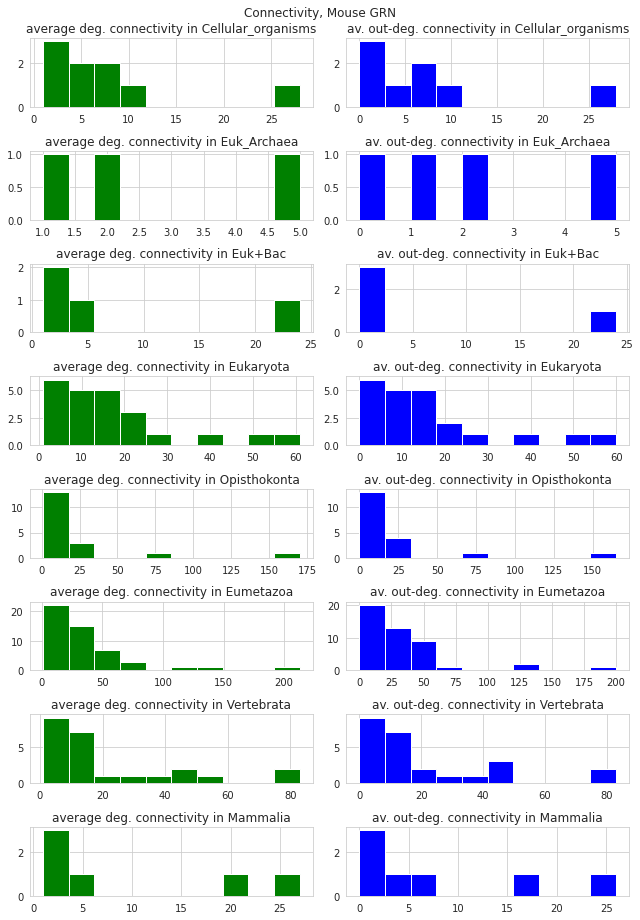

In [197]:
classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

plt.rcParams["figure.figsize"] = 9, 13
fig, axes = plt.subplots(8, 2)

for i, class_ in enumerate(classes[1:]):
    temp_data = mouse_data[mouse_data['TF_age'] == class_]
    
    temp_graph = nx.from_pandas_edgelist(temp_data, 
                                         'TF', 'Target', 
                                         ['Mode'],
                                         create_using=nx.DiGraph())

    #  is the average nearest neighbor degree of nodes with degree k
    temp_av_conn = nx.average_degree_connectivity(temp_graph)
    temp_out_conn = nx.average_degree_connectivity(temp_graph, source='out')

    axes[i, 0].hist(temp_av_conn, color='g')
    axes[i, 0].set_title(f'average deg. connectivity in {class_}')
    
    axes[i, 1].hist(temp_out_conn, color='b')
    axes[i, 1].set_title(f'av. out-deg. connectivity in {class_}')
    
plt.suptitle('Сonnectivity, Mouse GRN')
plt.tight_layout() 
plt.show()

#plt.savefig('../data/02_plots/mouse_connectivity.png')
#plt.close()

#### Clustering

In [198]:
clustering_table = pd.DataFrame(columns=['organism','class', 'type', 'clust_coefficient'])

In [199]:
# TF age

classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

for i, class_ in enumerate(classes[1:]):
    temp_data = mouse_data[mouse_data['TF_age'] == class_]
    
    if temp_data.empty:
        continue
    
    temp_graph = nx.from_pandas_edgelist(temp_data, 
                                         'TF', 'Target', 
                                         create_using=nx.DiGraph())

    clustering_table.loc[len(clustering_table)] = ['mouse', class_, 'TF', nx.average_clustering(temp_graph)]
    
    print(f'Clastering (transitivity):\t{round(nx.transitivity(temp_graph), 4)}, mouse, {class_}')
    print(f'Clastering coeficient:\t\t{round(nx.average_clustering(temp_graph), 6)}, mouse, {class_}')
    print('----------')

Clastering (transitivity):	0, mouse, Cellular_organisms
Clastering coeficient:		0.0, mouse, Cellular_organisms
----------
Clastering (transitivity):	0, mouse, Euk_Archaea
Clastering coeficient:		0.0, mouse, Euk_Archaea
----------
Clastering (transitivity):	0, mouse, Euk+Bac
Clastering coeficient:		0.0, mouse, Euk+Bac
----------
Clastering (transitivity):	0.0032, mouse, Eukaryota
Clastering coeficient:		0.013146, mouse, Eukaryota
----------
Clastering (transitivity):	0.0008, mouse, Opisthokonta
Clastering coeficient:		0.022709, mouse, Opisthokonta
----------
Clastering (transitivity):	0.0076, mouse, Eumetazoa
Clastering coeficient:		0.046803, mouse, Eumetazoa
----------
Clastering (transitivity):	0.0012, mouse, Vertebrata
Clastering coeficient:		0.007569, mouse, Vertebrata
----------
Clastering (transitivity):	0.0072, mouse, Mammalia
Clastering coeficient:		0.030158, mouse, Mammalia
----------


In [200]:
# Target age

classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

for i, class_ in enumerate(classes[1:]):
    temp_data = mouse_data[mouse_data['Tg_age'] == class_]
    
    if temp_data.empty:
        continue
    
    temp_graph = nx.from_pandas_edgelist(temp_data, 
                                         'TF', 'Target', 
                                         create_using=nx.DiGraph())

    clustering_table.loc[len(clustering_table)] = ['mouse', class_, 'TG', nx.average_clustering(temp_graph)]
    
    print(f'Clastering (transitivity):\t{round(nx.transitivity(temp_graph), 4)}, mouse, {class_}')
    print(f'Clastering coeficient:\t\t{round(nx.average_clustering(temp_graph), 6)}, mouse, {class_}')
    print('----------')

Clastering (transitivity):	0.0017, mouse, Cellular_organisms
Clastering coeficient:		0.001882, mouse, Cellular_organisms
----------
Clastering (transitivity):	0, mouse, Euk_Archaea
Clastering coeficient:		0.0, mouse, Euk_Archaea
----------
Clastering (transitivity):	0.0004, mouse, Euk+Bac
Clastering coeficient:		0.001401, mouse, Euk+Bac
----------
Clastering (transitivity):	0.0015, mouse, Eukaryota
Clastering coeficient:		0.00206, mouse, Eukaryota
----------
Clastering (transitivity):	0, mouse, Opisthokonta
Clastering coeficient:		0.0, mouse, Opisthokonta
----------
Clastering (transitivity):	0.005, mouse, Eumetazoa
Clastering coeficient:		0.018641, mouse, Eumetazoa
----------
Clastering (transitivity):	0.0029, mouse, Vertebrata
Clastering coeficient:		0.006346, mouse, Vertebrata
----------
Clastering (transitivity):	0.0022, mouse, Mammalia
Clastering coeficient:		0.003711, mouse, Mammalia
----------


In [201]:
# Clustering Result:
clustering_table

,organism,class,type,clust_coefficient
0,mouse,Cellular_organisms,TF,0.000000
1,mouse,Euk_Archaea,TF,0.000000
2,mouse,Euk+Bac,TF,0.000000
3,mouse,Eukaryota,TF,0.013146
4,mouse,Opisthokonta,TF,0.022709
5,mouse,Eumetazoa,TF,0.046803
6,mouse,Vertebrata,TF,0.007569
7,mouse,Mammalia,TF,0.030158
8,mouse,Cellular_organisms,TG,0.001882
9,mouse,Euk_Archaea,TG,0.000000


## 2.3. Heatmap <a name="Mouse_heatmap"></a>

In [202]:
# Substituting nans with "no info"
mouse_data[['Tg_age', 'TF_age']] = mouse_data[['Tg_age', 'TF_age']].replace(np.nan, 'no info')

In [203]:
heatmap_m = pd.crosstab(mouse_data.TF_age, mouse_data.Tg_age, normalize=True)
heatmap_m

Tg_age,Cellular_organisms,Euk+Bac,Euk_Archaea,Eukaryota,Eumetazoa,Mammalia,Opisthokonta,Vertebrata,no info
TF_age,,,,,,,,,
Cellular_organisms,0.000283,0.000425,0.000000,0.001134,0.003826,0.000850,0.000283,0.002267,0.000709
Euk+Bac,0.000142,0.000142,0.000000,0.000850,0.002126,0.000283,0.000425,0.001700,0.000142
Euk_Archaea,0.000000,0.000000,0.000000,0.000142,0.000425,0.000142,0.000000,0.000850,0.000142
Eukaryota,0.003117,0.006518,0.000850,0.014879,0.037551,0.007652,0.007369,0.021539,0.005526
Eumetazoa,0.017713,0.033442,0.001842,0.065325,0.201785,0.055123,0.031883,0.124699,0.032592
Mammalia,0.000283,0.000567,0.000000,0.000992,0.006235,0.000992,0.000850,0.002976,0.001275
Opisthokonta,0.002409,0.004251,0.000992,0.011620,0.034717,0.005243,0.004960,0.020122,0.004109
Vertebrata,0.002834,0.009069,0.000425,0.016296,0.047754,0.010061,0.007935,0.029049,0.008644
no info,0.002692,0.005810,0.000142,0.012753,0.028057,0.005101,0.003684,0.015729,0.004676


Text(0.5, 1.0, '          with clusterization coefficients')

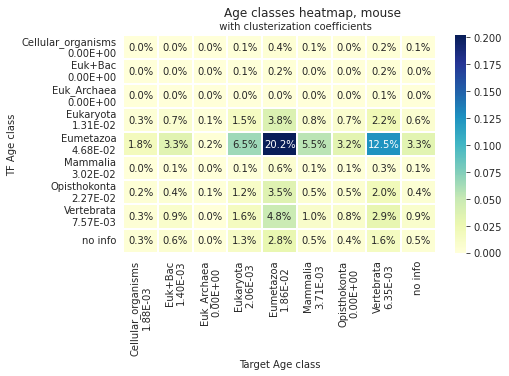

In [204]:
plt.rcParams["figure.figsize"] = 7, 4


xlabels = ['Cellular_organisms', 'Euk+Bac', 'Euk_Archaea', 'Eukaryota',
           'Eumetazoa', 'Mammalia', 'Opisthokonta', 'Vertebrata'] # labels for x-axis

ylabels = ['Cellular_organisms', 'Euk+Bac', 'Euk_Archaea', 'Eukaryota',
           'Eumetazoa', 'Mammalia', 'Opisthokonta', 'Vertebrata'] # labels for y-axis

x_axis_labels = []
y_axis_labels = []

for label in xlabels:
    coeff = clustering_table[(clustering_table['organism'] == 'mouse') 
                             & (clustering_table['class'] == label)
                             & (clustering_table['type'] == 'TG')].clust_coefficient.values[0]

    x_axis_labels.append(f'{label}\n{coeff:.2E}')
    
x_axis_labels.append('no info')
    
for label in ylabels:
    coeff = clustering_table[(clustering_table['organism'] == 'mouse') 
                             & (clustering_table['class'] == label)
                             & (clustering_table['type'] == 'TF')].clust_coefficient.values[0]

    y_axis_labels.append(f'{label}\n{coeff:.2E}')

y_axis_labels.append('no info')

s = sns.heatmap(heatmap_m,
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt=".1%", 
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
#plt.setp(s.get_xticklabels(), rotation=70)

plt.suptitle('Age classes heatmap, mouse')
plt.title('          with clusterization coefficients', size=10)

#plt.savefig('../data/02_plots/mouse_heatmap_01.png')
#plt.close()

#### Target/TF

In [205]:
tf_ages_count = mouse_data.groupby(['TF', 'TF_age'], as_index=0).count().groupby('TF_age', as_index=0).count()[['TF_age', 'TF']]
tg_ages_count = mouse_data.groupby(['Target', 'Tg_age'], as_index=0).count().groupby('Tg_age', as_index=0).count()[['Tg_age', 'Target']]

In [206]:
ages_list = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
             'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

tf_tg_count = heatmap_m.copy()

for tf_age in ages_list:
    for tg_age in ages_list:
        new_table = mouse_data[(mouse_data.Tg_age == tg_age) & (mouse_data.TF_age == tf_age)]
        if new_table[['TF']].nunique().iloc[0] != 0:
            new_value = new_table[['Target']].nunique().iloc[0] / new_table[['TF']].nunique().iloc[0]
        else:
            new_value = 0
        tf_tg_count.loc[tf_age, tg_age] = new_value

In [207]:
tf_tg_count

Tg_age,Cellular_organisms,Euk+Bac,Euk_Archaea,Eukaryota,Eumetazoa,Mammalia,Opisthokonta,Vertebrata,no info
TF_age,,,,,,,,,
Cellular_organisms,1.000000,1.000000,0.00,2.000000,3.000000,1.000000,2.000000,2.666667,2.500000
Euk+Bac,1.000000,1.000000,0.00,6.000000,2.500000,0.500000,1.000000,3.000000,1.000000
Euk_Archaea,0.000000,0.000000,0.00,1.000000,1.000000,1.000000,0.000000,1.500000,1.000000
Eukaryota,1.583333,1.760000,1.20,1.784314,2.009346,1.305556,1.642857,1.842857,1.500000
Eumetazoa,1.652174,1.914286,1.00,1.953608,2.280556,1.795031,1.551181,2.246094,1.519685
Mammalia,1.000000,1.333333,0.00,1.166667,2.055556,2.333333,1.500000,1.266667,2.000000
Opisthokonta,1.888889,2.636364,1.75,3.208333,4.134615,2.125000,1.590909,3.657143,1.812500
Vertebrata,1.200000,2.192308,1.00,2.311111,3.157303,1.658537,1.666667,2.707692,1.555556
no info,4.500000,5.571429,1.00,5.250000,4.309524,2.400000,2.000000,3.642857,2.538462


Text(0.5, 1.0, 'TG/TF heatmap, mouse')

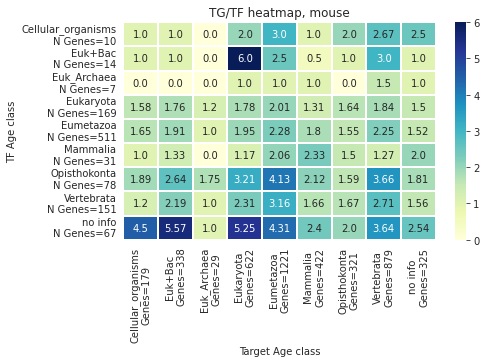

In [208]:
plt.rcParams["figure.figsize"] = 7, 4


xlabels = ['Cellular_organisms', 'Euk+Bac', 'Euk_Archaea', 'Eukaryota',
           'Eumetazoa', 'Mammalia', 'Opisthokonta', 'Vertebrata', 'no info'] # labels for x-axis

ylabels = ['Cellular_organisms', 'Euk+Bac', 'Euk_Archaea', 'Eukaryota',
           'Eumetazoa', 'Mammalia', 'Opisthokonta', 'Vertebrata', 'no info'] # labels for y-axis


x_axis_labels = []
y_axis_labels = []

for label in xlabels:
    x_axis_labels.append(f'{label}\nGenes={tg_ages_count[tg_ages_count.Tg_age == label].Target.iloc[0]}')
    
#x_axis_labels.append('no info')
    
for label in ylabels:
    y_axis_labels.append(f'{label}\nN Genes={tf_ages_count[tf_ages_count.TF_age == label].TF.iloc[0]}')

#y_axis_labels.append('no info')

s = sns.heatmap(tf_tg_count,
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt=".3",
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
#plt.setp(s.get_xticklabels(), rotation=70)

plt.title('TG/TF heatmap, mouse')
#plt.savefig('../data/02_plots/mouse_heatmap_02.png')
#plt.close()

## 2.4.  Edge "len"  <a name="Mouse_len"></a>


In [209]:
# str to numbers
classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

mouse_data['Tg_age'] = mouse_data['Tg_age'].apply(lambda x: classes.index(x))
mouse_data['TF_age'] = mouse_data['TF_age'].apply(lambda x: classes.index(x))

mouse_data['age_length'] = np.where((mouse_data['TF_age'] == 0) | (mouse_data['Tg_age'] == 0),
                                     -1,
                                     abs(mouse_data['TF_age'] - mouse_data['Tg_age']))

# no info to NAN
mouse_data['age_length'] = mouse_data['age_length'].replace({-1: np.nan})

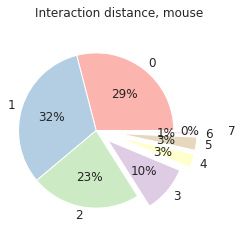

In [255]:
# plot

plt.rcParams["figure.figsize"] = 4, 4

idx = [0, 1, 2, 3, 4, 5, 6, 7]
counts = pd.Series(mouse_data['age_length'].value_counts(normalize=True) * 100)
counts.index = counts.index.astype('int64')
counts = counts[idx]

explode = (0, 0, 0, 0.2, 0.3, 0.3, 0.3, 0.6)

counts.plot(kind='pie', fontsize=12, colormap="Pastel1", explode=explode,  autopct='%.0f%%')
plt.axis('equal')
plt.ylabel('')
plt.title('Interaction distance, mouse')
plt.show()
#plt.savefig('../data/02_plots/mouse_age_len.png')
#plt.close()

# 3. Human <a name="Human"></a>

## 3.1. Download and mapping age classes to nx graph <a name="Human_mapping"></a>

In [225]:
human_classes = pd.read_csv('../data/02_protein_ages/main_HUMAN.csv')
print(human_classes.shape)

human_classes = human_classes.rename(columns={"Unnamed: 0": "Protein"})
human_classes.head()

(20331, 16)


,Protein,Cellular_organisms,Euk_Archaea,Euk+Bac,Eukaryota,Opisthokonta,Eumetazoa,Vertebrata,Mammalia,modeAge,NumDBsContributing,NumDBsFiltered,entropy,NodeError,Bimodality,HGT_flag
0,A0A075B6G5,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,Eumetazoa,1,1,-0.000000,6.0,NaN,False
1,A0A075B6R3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,Mammalia,2,1,-0.000000,10.6666666667,16.0,False
2,A0A0A0MR89,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,Eumetazoa,1,1,-0.000000,1.0,NaN,False
3,A0A0A0MS98,0.0,0.0,0.0,0.0,0.0,0.454545,0.0,0.545455,Mammalia,11,1,0.689009,5.68181818182,1.8,False
4,A0A0A0MSJ3,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,Eukaryota,2,0,-0.000000,1.0,NaN,False


In [226]:
# for uniprot mapping - https://www.uniprot.org/uploadlists/

human_ID_UniProt = list(human_classes['Protein'])

with open('../data/02_age_classes/human_ID_UniProt.txt', 'w') as f:
    for el in human_ID_UniProt:
        f.write(el+' ')

 ... https://www.uniprot.org/uploadlists/ ...

In [227]:
# load protein-gene table:
human_prot_genes = pd.read_csv('../data/02_age_classes/human_UniProtMapping.txt',
                                  sep='\t',
                                  engine='python',
                                  names=['Protein', 'Gene'],
                                  header=1)
human_prot_genes.head()

,Protein,Gene
0,A0A075B6R3,HELZ
1,A0A0A0MR89,NRXN3
2,A0A0A0MS98,SLC4A1
3,A0A0A0MSL8,RBM14-RBM4
4,A0A0A0MTC1,RNF213


In [228]:
# add gene names to protein classes table:
human_classes = human_classes.merge(human_prot_genes, how='outer', on=['Protein'])
human_classes.head()

,Protein,Cellular_organisms,Euk_Archaea,Euk+Bac,Eukaryota,Opisthokonta,Eumetazoa,Vertebrata,Mammalia,modeAge,NumDBsContributing,NumDBsFiltered,entropy,NodeError,Bimodality,HGT_flag,Gene
0,A0A075B6G5,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,Eumetazoa,1,1,-0.000000,6.0,NaN,False,NaN
1,A0A075B6R3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,Mammalia,2,1,-0.000000,10.6666666667,16.0,False,HELZ
2,A0A0A0MR89,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,Eumetazoa,1,1,-0.000000,1.0,NaN,False,NRXN3
3,A0A0A0MS98,0.0,0.0,0.0,0.0,0.0,0.454545,0.0,0.545455,Mammalia,11,1,0.689009,5.68181818182,1.8,False,SLC4A1
4,A0A0A0MSJ3,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,Eukaryota,2,0,-0.000000,1.0,NaN,False,NaN


In [229]:
human_classes.shape

(20479, 17)

In [230]:
# Let's leave only those lines that are needed for our GRN:
human_TFTG = set(list(human_data.TF) + list(human_data.Target))

human_gene_ages = human_classes.query('Gene in @human_TFTG')
print(human_gene_ages.shape)
human_gene_ages.head()

(2855, 17)


,Protein,Cellular_organisms,Euk_Archaea,Euk+Bac,Eukaryota,Opisthokonta,Eumetazoa,Vertebrata,Mammalia,modeAge,NumDBsContributing,NumDBsFiltered,entropy,NodeError,Bimodality,HGT_flag,Gene
23,A0AVK6,0.0,0.0,0.0,0.700000,0.0,0.000000,0.300000,0.0,Eukaryota,10,3,0.610864,4.51282051282,2.861111,False,E2F8
94,A2AB90,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.0,Vertebrata,6,1,-0.000000,1.14285714286,4.000000,False,TAPBP
96,A2ADX3,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.0,Vertebrata,4,1,-0.000000,0.0,NaN,False,HLA-DQB2
196,A6H8Y1,0.0,0.0,0.0,0.666667,0.0,0.333333,0.000000,0.0,Eukaryota,9,4,0.636514,6.35897435897,0.357143,False,BDP1
501,A6NNB3,0.0,0.0,0.0,0.000000,0.0,0.083333,0.916667,0.0,Vertebrata,12,1,0.286836,0.74358974359,0.091270,False,IFITM5


In [231]:
# Class distribution
human_sum_ages = human_gene_ages.groupby('modeAge', as_index=0).count()[['modeAge', 'Gene']]
human_sum_ages.loc["Total"] = human_sum_ages.sum()
human_sum_ages.loc['Total', 'modeAge'] = 'Total'
human_sum_ages.rename(columns = {'modeAge':'Age class', 'Gene': 'Genes number'}, inplace = True)
human_sum_ages

,Age class,Genes number
0,Cellular_organisms,145
1,Euk+Bac,230
2,Euk_Archaea,27
3,Eukaryota,650
4,Eumetazoa,891
5,Mammalia,212
6,Opisthokonta,167
7,Vertebrata,533
Total,Total,2855


#### Add New info to Graf:

In [232]:
human_attrs = human_gene_ages[['Gene', 'modeAge']].set_index('Gene').T.to_dict('dict')
nx.set_node_attributes(human_graph, human_attrs) 

/tmp/ipykernel_40539/3792171582.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  human_attrs = human_gene_ages[['Gene', 'modeAge']].set_index('Gene').T.to_dict('dict')


Связь-возраст

In [233]:
# Add New info to pandas df:

human_gene_ages = human_gene_ages.rename(columns = {'Gene':'TF'})
human_data['TF_age'] =  human_data.merge(human_gene_ages[['TF', 'modeAge']], how='left', on=['TF']).modeAge

human_gene_ages = human_gene_ages.rename(columns = {'TF':'Target'})
human_data['Tg_age'] =  human_data.merge(human_gene_ages[['Target', 'modeAge']], how='left', on=['Target']).modeAge

# return name
human_gene_ages = human_gene_ages.rename(columns = {'Target':'Gene'})

In [234]:
# сохраним датафрейм
human_data.to_csv('../data/02_age_classes/trrust_rawdata.human_classes.csv')

human_data.head()

,TF,Target,Mode,PMID,TF_age,Tg_age
0,AATF,BAX,Repression,22909821,Eukaryota,Eumetazoa
1,AATF,CDKN1A,Unknown,17157788,Eukaryota,Eumetazoa
2,AATF,KLK3,Unknown,23146908,Eukaryota,Mammalia
3,AATF,MYC,Activation,20549547,Eukaryota,Eumetazoa
4,AATF,TP53,Unknown,17157788,Eukaryota,Opisthokonta


## 3.2. Degree connectivity and clustering <a name="Human_connectivity"></a>

In [235]:
human_gene_ages_dropped = human_gene_ages[['Gene', 'modeAge']]

human_ndegree = pd.DataFrame.from_dict(dict(human_graph.degree()), orient='index').reset_index(level=0)
human_ndegree.columns = ['Gene', 'Node_Degree']

human_ndegree = human_ndegree.merge(human_gene_ages_dropped, how='outer', on=['Gene'])

human_ndegree.head()

,Gene,Node_Degree,modeAge
0,AATF,5,Eukaryota
1,BAX,26,Eumetazoa
2,CDKN1A,115,Eumetazoa
3,KLK3,25,Mammalia
4,MYC,174,Eumetazoa


In [236]:
classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

human_ndegree['modeAge'].fillna('no info', inplace=True)
human_ndegree['Age'] = human_ndegree['modeAge'].apply(lambda x: classes.index(x))

Text(0, 0.5, 'Age class')

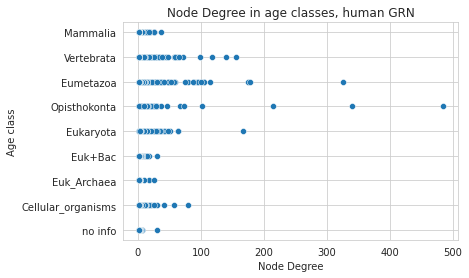

In [237]:
plt.figure(figsize=(6, 4))

human_ndegree['modeAge'] = [classes.index(x) for x in human_ndegree['modeAge']]
sns.scatterplot(y="modeAge", x="Node_Degree", data=human_ndegree)
plt.yticks(range(len(classes)), classes)

plt.title('Node Degree in age classes, human GRN')
plt.xlabel('Node Degree')
plt.ylabel('Age class')
#plt.savefig('../data/02_plots/human_node_degree.png')
#plt.close()

#### Сonnectivity

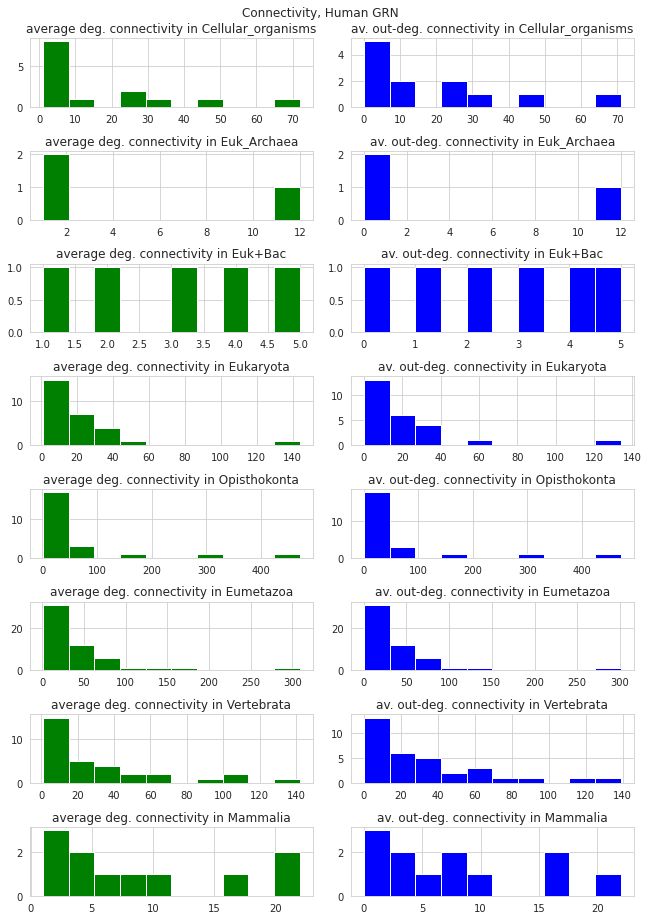

In [238]:
classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

plt.rcParams["figure.figsize"] = 9, 13
fig, axes = plt.subplots(8, 2)

for i, class_ in enumerate(classes[1:]):
    temp_data = human_data[human_data['TF_age'] == class_]
    
    temp_graph = nx.from_pandas_edgelist(temp_data, 
                                         'TF', 'Target', 
                                         ['Mode'],
                                         create_using=nx.DiGraph())

    #  is the average nearest neighbor degree of nodes with degree k
    temp_av_conn = nx.average_degree_connectivity(temp_graph)
    temp_out_conn = nx.average_degree_connectivity(temp_graph, source='out')

    axes[i, 0].hist(temp_av_conn, color='g')
    axes[i, 0].set_title(f'average deg. connectivity in {class_}')
    
    axes[i, 1].hist(temp_out_conn, color='b')
    axes[i, 1].set_title(f'av. out-deg. connectivity in {class_}')

plt.suptitle('Сonnectivity, Human GRN')
plt.tight_layout() 
plt.show()

#plt.savefig('../data/02_plots/human_connectivity.png')
#plt.close()

#### Clustering

In [239]:
clustering_table = pd.DataFrame(columns=['organism','class', 'type', 'clust_coefficient'])

In [240]:
# TF age

classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

for i, class_ in enumerate(classes[1:]):
    temp_data = human_data[human_data['TF_age'] == class_]
    
    if temp_data.empty:
        continue
    
    temp_graph = nx.from_pandas_edgelist(temp_data, 
                                         'TF', 'Target', 
                                         create_using=nx.DiGraph())

    clustering_table.loc[len(clustering_table)] = ['human', class_, 'TF', nx.average_clustering(temp_graph)]
    
    print(f'Clastering (transitivity):\t{round(nx.transitivity(temp_graph), 4)}, human, {class_}')
    print(f'Clastering coeficient:\t\t{round(nx.average_clustering(temp_graph), 6)}, human, {class_}')
    print('----------')

Clastering (transitivity):	0.0029, human, Cellular_organisms
Clastering coeficient:		0.047118, human, Cellular_organisms
----------
Clastering (transitivity):	0, human, Euk_Archaea
Clastering coeficient:		0.0, human, Euk_Archaea
----------
Clastering (transitivity):	0, human, Euk+Bac
Clastering coeficient:		0.0, human, Euk+Bac
----------
Clastering (transitivity):	0.0033, human, Eukaryota
Clastering coeficient:		0.021748, human, Eukaryota
----------
Clastering (transitivity):	0.0011, human, Opisthokonta
Clastering coeficient:		0.071422, human, Opisthokonta
----------
Clastering (transitivity):	0.0042, human, Eumetazoa
Clastering coeficient:		0.028491, human, Eumetazoa
----------
Clastering (transitivity):	0.0025, human, Vertebrata
Clastering coeficient:		0.027444, human, Vertebrata
----------
Clastering (transitivity):	0.0008, human, Mammalia
Clastering coeficient:		0.000637, human, Mammalia
----------


In [241]:
# Target age

classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

for i, class_ in enumerate(classes[1:]):
    temp_data = human_data[human_data['Tg_age'] == class_]
    
    if temp_data.empty:
        continue
    
    temp_graph = nx.from_pandas_edgelist(temp_data, 
                                         'TF', 'Target', 
                                         create_using=nx.DiGraph())

    clustering_table.loc[len(clustering_table)] = ['human', class_, 'TG', nx.average_clustering(temp_graph)]
    
    print(f'Clastering (transitivity):\t{round(nx.transitivity(temp_graph), 4)}, human, {class_}')
    print(f'Clastering coeficient:\t\t{round(nx.average_clustering(temp_graph), 6)}, human, {class_}')
    print('----------')

Clastering (transitivity):	0, human, Cellular_organisms
Clastering coeficient:		0.0, human, Cellular_organisms
----------
Clastering (transitivity):	0, human, Euk_Archaea
Clastering coeficient:		0.0, human, Euk_Archaea
----------
Clastering (transitivity):	0.0003, human, Euk+Bac
Clastering coeficient:		0.001341, human, Euk+Bac
----------
Clastering (transitivity):	0.002, human, Eukaryota
Clastering coeficient:		0.005287, human, Eukaryota
----------
Clastering (transitivity):	0.0007, human, Opisthokonta
Clastering coeficient:		0.001217, human, Opisthokonta
----------
Clastering (transitivity):	0.0042, human, Eumetazoa
Clastering coeficient:		0.015829, human, Eumetazoa
----------
Clastering (transitivity):	0.0032, human, Vertebrata
Clastering coeficient:		0.015464, human, Vertebrata
----------
Clastering (transitivity):	0.0019, human, Mammalia
Clastering coeficient:		0.006275, human, Mammalia
----------


In [242]:
clustering_table

,organism,class,type,clust_coefficient
0,human,Cellular_organisms,TF,0.047118
1,human,Euk_Archaea,TF,0.000000
2,human,Euk+Bac,TF,0.000000
3,human,Eukaryota,TF,0.021748
4,human,Opisthokonta,TF,0.071422
5,human,Eumetazoa,TF,0.028491
6,human,Vertebrata,TF,0.027444
7,human,Mammalia,TF,0.000637
8,human,Cellular_organisms,TG,0.000000
9,human,Euk_Archaea,TG,0.000000


## 3.3. Heatmap <a name="Human_heatmap"></a>

In [243]:
# Substituting nans with "no info"
human_data[['Tg_age', 'TF_age']] = human_data[['Tg_age', 'TF_age']].replace(np.nan, 'no info')

In [244]:
heatmap_h = pd.crosstab(human_data.TF_age, human_data.Tg_age, normalize=True)
heatmap_h

Tg_age,Cellular_organisms,Euk+Bac,Euk_Archaea,Eukaryota,Eumetazoa,Mammalia,Opisthokonta,Vertebrata,no info
TF_age,,,,,,,,,
Cellular_organisms,0.001596,0.001490,0.000639,0.003938,0.007237,0.002874,0.002554,0.007131,0.000319
Euk+Bac,0.000106,0.000213,0.000000,0.000213,0.001064,0.000000,0.000213,0.001064,0.000000
Euk_Archaea,0.000000,0.000000,0.000000,0.000532,0.000851,0.000000,0.000106,0.000639,0.000000
Eukaryota,0.005960,0.008195,0.001064,0.024585,0.036292,0.007237,0.010856,0.021605,0.001703
Eumetazoa,0.020966,0.032993,0.002980,0.075458,0.151022,0.035653,0.031503,0.120690,0.004683
Mammalia,0.001064,0.000639,0.000106,0.002767,0.004470,0.001171,0.001809,0.002980,0.000319
Opisthokonta,0.009685,0.016177,0.001171,0.032035,0.060983,0.015432,0.012239,0.042891,0.001703
Vertebrata,0.008408,0.012771,0.001596,0.028203,0.048531,0.011920,0.010536,0.036718,0.002022
no info,0.000745,0.000532,0.000106,0.001916,0.000745,0.000319,0.000106,0.000958,0.000000


Text(0.5, 1.0, '          with clusterization coefficients')

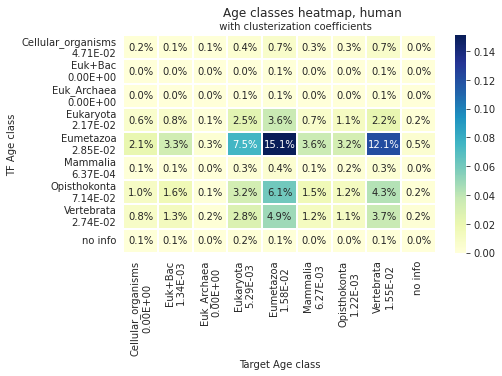

In [245]:
plt.rcParams["figure.figsize"] = 7, 4


xlabels = ['Cellular_organisms', 'Euk+Bac', 'Euk_Archaea', 'Eukaryota',
           'Eumetazoa', 'Mammalia', 'Opisthokonta', 'Vertebrata'] # labels for x-axis

ylabels = ['Cellular_organisms', 'Euk+Bac', 'Euk_Archaea', 'Eukaryota',
           'Eumetazoa', 'Mammalia', 'Opisthokonta', 'Vertebrata'] # labels for y-axis

x_axis_labels = []
y_axis_labels = []

for label in xlabels:
    coeff = clustering_table[(clustering_table['organism'] == 'human') 
                             & (clustering_table['class'] == label)
                             & (clustering_table['type'] == 'TG')].clust_coefficient.values[0]

    x_axis_labels.append(f'{label}\n{coeff:.2E}')
    
x_axis_labels.append('no info')
    
for label in ylabels:
    coeff = clustering_table[(clustering_table['organism'] == 'human') 
                             & (clustering_table['class'] == label)
                             & (clustering_table['type'] == 'TF')].clust_coefficient.values[0]

    y_axis_labels.append(f'{label}\n{coeff:.2E}')

y_axis_labels.append('no info')

s = sns.heatmap(heatmap_h,
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt=".1%",
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
plt.suptitle('Age classes heatmap, human')
plt.title('          with clusterization coefficients', size=10)

#plt.savefig('../data/02_plots/human_heatmap_01.png')
#plt.close()

#### Target/TF

In [246]:
tf_ages_count = human_data.groupby(['TF', 'TF_age'], as_index=0).count().groupby('TF_age', as_index=0).count()[['TF_age', 'TF']]
tg_ages_count = human_data.groupby(['Target', 'Tg_age'], as_index=0).count().groupby('Tg_age', as_index=0).count()[['Tg_age', 'Target']]

In [247]:
ages_list = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
             'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

tf_tg_count = heatmap_h.copy()

for tf_age in ages_list:
    for tg_age in ages_list:
        new_table = human_data[(human_data.Tg_age == tg_age) & (human_data.TF_age == tf_age)]
        
        if new_table[['TF']].nunique().iloc[0] != 0:
            new_value = new_table[['Target']].nunique().iloc[0] / new_table[['TF']].nunique().iloc[0]
        
        else:
            new_value = 0
        
        tf_tg_count.loc[tf_age, tg_age] = new_value

In [248]:
tf_tg_count

Tg_age,Cellular_organisms,Euk+Bac,Euk_Archaea,Eukaryota,Eumetazoa,Mammalia,Opisthokonta,Vertebrata,no info
TF_age,,,,,,,,,
Cellular_organisms,2.333333,2.000000,1.250000,3.500000,8.000000,2.888889,2.300000,6.666667,1.000000
Euk+Bac,1.000000,1.000000,0.000000,2.000000,1.666667,0.000000,2.000000,1.428571,0.000000
Euk_Archaea,0.000000,0.000000,0.000000,1.250000,2.000000,0.000000,1.000000,2.000000,0.000000
Eukaryota,1.432432,1.543478,3.333333,2.253012,2.292453,1.512195,1.714286,2.215190,1.333333
Eumetazoa,1.575472,2.115702,1.227273,2.344660,2.958333,2.129032,2.016807,2.649254,1.212121
Mammalia,1.428571,1.200000,1.000000,1.733333,2.562500,1.222222,1.545455,1.800000,1.500000
Opisthokonta,4.047619,6.043478,2.200000,5.577778,7.080645,5.000000,3.448276,7.761905,1.666667
Vertebrata,2.517241,3.111111,1.555556,3.303030,4.358974,2.885714,2.315789,4.058824,1.583333
no info,3.500000,1.250000,1.000000,2.428571,1.166667,1.000000,1.000000,1.333333,0.000000


Text(0.5, 1.0, 'TG/TF heatmap, human')

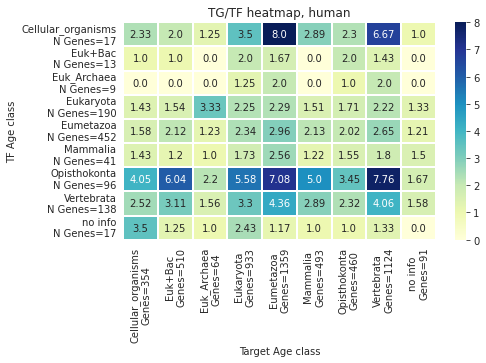

In [249]:
plt.rcParams["figure.figsize"] = 7, 4


xlabels = ['Cellular_organisms', 'Euk+Bac', 'Euk_Archaea', 'Eukaryota',
           'Eumetazoa', 'Mammalia', 'Opisthokonta', 'Vertebrata', 'no info'] # labels for x-axis

ylabels = ['Cellular_organisms', 'Euk+Bac', 'Euk_Archaea', 'Eukaryota',
           'Eumetazoa', 'Mammalia', 'Opisthokonta', 'Vertebrata', 'no info'] # labels for y-axis


x_axis_labels = []
y_axis_labels = []

for label in xlabels:
    x_axis_labels.append(f'{label}\nGenes={tg_ages_count[tg_ages_count.Tg_age == label].Target.iloc[0]}')
    
#x_axis_labels.append('no info')
    
for label in ylabels:
    y_axis_labels.append(f'{label}\nN Genes={tf_ages_count[tf_ages_count.TF_age == label].TF.iloc[0]}')

#y_axis_labels.append('no info')

s = sns.heatmap(tf_tg_count,
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt=".3",
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
plt.title('TG/TF heatmap, human')
#plt.savefig('../data/02_plots/human_heatmap_02.png')
#plt.close()

## 3.4.  Edge "len"  <a name="Human_len"></a>


In [250]:
# str to numbers
classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

human_data['Tg_age'] = human_data['Tg_age'].apply(lambda x: classes.index(x))
human_data['TF_age'] = human_data['TF_age'].apply(lambda x: classes.index(x))

human_data['age_length'] = np.where((human_data['TF_age'] == 0) | (human_data['Tg_age'] == 0),
                                     -1,
                                     abs(human_data['TF_age'] - human_data['Tg_age']))

# no info to NAN
human_data['age_length'] = human_data['age_length'].replace({-1: np.nan})

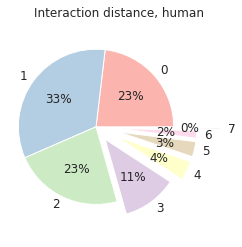

In [253]:
# plot

plt.rcParams["figure.figsize"] = 4, 4

idx = [0, 1, 2, 3, 4, 5, 6, 7]
counts = pd.Series(human_data['age_length'].value_counts(normalize=True) * 100)
counts.index = counts.index.astype('int64')
counts = counts[idx]

explode = (0, 0, 0, 0.2, 0.3, 0.3, 0.3, 0.6)

counts.plot(kind='pie', fontsize=12, colormap="Pastel1", explode=explode,  autopct='%.0f%%')
plt.axis('equal')
plt.ylabel('')
plt.title('Interaction distance, human')
plt.show()
#plt.savefig('../data/02_plots/human_age_len.png')
#plt.close()